In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer

print(tf.__version__)

1.13.1


# Loading Movie Review Dataset

In [2]:
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
        fname="aclImdb.tar.gz",
        origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
        extract=True)
    
    train_df = load_dataset(os.path.join(os.path.dirname(dataset),
                                        "aclImdb", "train"))
    
    test_df = load_dataset(os.path.join(os.path.dirname(dataset),
                                        "aclImdb", "test"))
    return train_df, test_df

In [3]:
train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,"i know you've read that before, on countless o...",1,0
1,I'm not sure why Spike Lee made this train wre...,4,0
2,There are so many words I want to use to descr...,10,1
3,drss1942 really took the words right out of my...,1,0
4,This centers on unironic notions of coming to ...,4,0


# Model

The estimator framework lets use wrap dataframes with input functions. It handles the details of initialisation, logging, saving and restoring of a tensorflow model.

In [4]:
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)

predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

TF-Hub provides a feature column that applies a module onto a given text feature and passes the outputs on. In this case, we're using the nnlm-en-dim128module which will:
* take in the batch of 1D string tensors as input
* preprocess sentences (eg. remove punctuation and split strings)
* take any input - words not present in vocab are hashed into buckets

In [5]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

Now, we're going to define an estimator using a DNN classifier - it will infer what premade estimator to use off the criteria we set

# Training

In [12]:
estimator = tf.estimator.DNNClassifier(hidden_units=[500,100],
                                      feature_columns=[embedded_text_feature_column],
                                      n_classes=2,
                                      optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

INFO:tensorflow:Using default config.


I0408 21:58:45.446080 140296980215616 estimator.py:1739] Using default config.


W0408 21:58:45.447455 140296980215616 estimator.py:1760] Using temporary folder as model directory: /tmp/tmpmlu8d_w0


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmlu8d_w0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f992951e240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0408 21:58:45.448152 140296980215616 estimator.py:201] Using config: {'_model_dir': '/tmp/tmpmlu8d_w0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f992951e240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [11]:
runConfig = tf.ConfigProto(device_count={'GPU': 1})

# Training

In [13]:
estimator.train(input_fn=train_input_fn, steps=3000)

Instructions for updating:
Colocations handled automatically by placer.


W0408 21:58:58.006723 140296980215616 deprecation.py:323] From /home/eigenstir/anaconda3/envs/tf2alpha/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0408 21:58:58.018294 140296980215616 deprecation.py:323] From /home/eigenstir/anaconda3/envs/tf2alpha/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0408 21:58:58.019917 140296980215616 deprecation.py:323] From /home/eigenstir/anaconda3/envs/tf2alpha/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_functions.py:500: add_queue_runner (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Calling model_fn.


I0408 21:58:58.025899 140296980215616 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 21:58:58.051789 140296980215616 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 21:58:58.076300 140296980215616 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.cast instead.


W0408 21:58:58.150726 140296980215616 deprecation.py:323] From /home/eigenstir/anaconda3/envs/tf2alpha/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/head.py:436: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Done calling model_fn.


I0408 21:58:58.295161 140296980215616 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0408 21:58:58.296347 140296980215616 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0408 21:58:58.432659 140296980215616 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0408 21:58:58.734959 140296980215616 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0408 21:58:59.222648 140296980215616 session_manager.py:493] Done running local_init_op.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0408 21:58:59.234400 140296980215616 deprecation.py:323] From /home/eigenstir/anaconda3/envs/tf2alpha/lib/python3.7/site-packages/tensorflow/python/training/monitored_session.py:809: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpmlu8d_w0/model.ckpt.


I0408 21:58:59.414944 140296980215616 basic_session_run_hooks.py:594] Saving checkpoints for 0 into /tmp/tmpmlu8d_w0/model.ckpt.


INFO:tensorflow:loss = 89.0346, step = 1


I0408 21:58:59.876101 140296980215616 basic_session_run_hooks.py:249] loss = 89.0346, step = 1


INFO:tensorflow:global_step/sec: 102.242


I0408 21:59:00.853943 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 102.242


INFO:tensorflow:loss = 63.46975, step = 101 (0.979 sec)


I0408 21:59:00.855256 140296980215616 basic_session_run_hooks.py:247] loss = 63.46975, step = 101 (0.979 sec)


INFO:tensorflow:global_step/sec: 109.403


I0408 21:59:01.768000 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 109.403


INFO:tensorflow:loss = 54.113426, step = 201 (0.914 sec)


I0408 21:59:01.769338 140296980215616 basic_session_run_hooks.py:247] loss = 54.113426, step = 201 (0.914 sec)


INFO:tensorflow:global_step/sec: 107.866


I0408 21:59:02.695072 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 107.866


INFO:tensorflow:loss = 65.064705, step = 301 (0.928 sec)


I0408 21:59:02.696904 140296980215616 basic_session_run_hooks.py:247] loss = 65.064705, step = 301 (0.928 sec)


INFO:tensorflow:global_step/sec: 109.705


I0408 21:59:03.606607 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 109.705


INFO:tensorflow:loss = 54.426918, step = 401 (0.911 sec)


I0408 21:59:03.607916 140296980215616 basic_session_run_hooks.py:247] loss = 54.426918, step = 401 (0.911 sec)


INFO:tensorflow:global_step/sec: 110.499


I0408 21:59:04.511596 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 110.499


INFO:tensorflow:loss = 58.1257, step = 501 (0.905 sec)


I0408 21:59:04.513095 140296980215616 basic_session_run_hooks.py:247] loss = 58.1257, step = 501 (0.905 sec)


INFO:tensorflow:global_step/sec: 109.411


I0408 21:59:05.425572 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 109.411


INFO:tensorflow:loss = 47.28546, step = 601 (0.914 sec)


I0408 21:59:05.426677 140296980215616 basic_session_run_hooks.py:247] loss = 47.28546, step = 601 (0.914 sec)


INFO:tensorflow:global_step/sec: 110.482


I0408 21:59:06.330715 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 110.482


INFO:tensorflow:loss = 50.472794, step = 701 (0.905 sec)


I0408 21:59:06.332062 140296980215616 basic_session_run_hooks.py:247] loss = 50.472794, step = 701 (0.905 sec)


INFO:tensorflow:global_step/sec: 108.386


I0408 21:59:07.253322 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 108.386


INFO:tensorflow:loss = 55.068832, step = 801 (0.923 sec)


I0408 21:59:07.254653 140296980215616 basic_session_run_hooks.py:247] loss = 55.068832, step = 801 (0.923 sec)


INFO:tensorflow:global_step/sec: 110.614


I0408 21:59:08.157365 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 110.614


INFO:tensorflow:loss = 46.56905, step = 901 (0.904 sec)


I0408 21:59:08.158708 140296980215616 basic_session_run_hooks.py:247] loss = 46.56905, step = 901 (0.904 sec)


INFO:tensorflow:global_step/sec: 109.126


I0408 21:59:09.073741 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 109.126


INFO:tensorflow:loss = 50.973755, step = 1001 (0.917 sec)


I0408 21:59:09.075211 140296980215616 basic_session_run_hooks.py:247] loss = 50.973755, step = 1001 (0.917 sec)


INFO:tensorflow:global_step/sec: 109.37


I0408 21:59:09.988064 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 109.37


INFO:tensorflow:loss = 57.736343, step = 1101 (0.914 sec)


I0408 21:59:09.989464 140296980215616 basic_session_run_hooks.py:247] loss = 57.736343, step = 1101 (0.914 sec)


INFO:tensorflow:global_step/sec: 110.344


I0408 21:59:10.894320 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 110.344


INFO:tensorflow:loss = 51.437916, step = 1201 (0.906 sec)


I0408 21:59:10.895634 140296980215616 basic_session_run_hooks.py:247] loss = 51.437916, step = 1201 (0.906 sec)


INFO:tensorflow:global_step/sec: 107.973


I0408 21:59:11.820478 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 107.973


INFO:tensorflow:loss = 51.86078, step = 1301 (0.926 sec)


I0408 21:59:11.821646 140296980215616 basic_session_run_hooks.py:247] loss = 51.86078, step = 1301 (0.926 sec)


INFO:tensorflow:global_step/sec: 110.068


I0408 21:59:12.729003 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 110.068


INFO:tensorflow:loss = 58.44487, step = 1401 (0.909 sec)


I0408 21:59:12.730296 140296980215616 basic_session_run_hooks.py:247] loss = 58.44487, step = 1401 (0.909 sec)


INFO:tensorflow:global_step/sec: 109.027


I0408 21:59:13.646210 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 109.027


INFO:tensorflow:loss = 52.577824, step = 1501 (0.918 sec)


I0408 21:59:13.647929 140296980215616 basic_session_run_hooks.py:247] loss = 52.577824, step = 1501 (0.918 sec)


INFO:tensorflow:global_step/sec: 107.832


I0408 21:59:14.573579 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 107.832


INFO:tensorflow:loss = 49.479126, step = 1601 (0.927 sec)


I0408 21:59:14.575004 140296980215616 basic_session_run_hooks.py:247] loss = 49.479126, step = 1601 (0.927 sec)


INFO:tensorflow:global_step/sec: 109.167


I0408 21:59:15.489607 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 109.167


INFO:tensorflow:loss = 62.003838, step = 1701 (0.916 sec)


I0408 21:59:15.490818 140296980215616 basic_session_run_hooks.py:247] loss = 62.003838, step = 1701 (0.916 sec)


INFO:tensorflow:global_step/sec: 107.201


I0408 21:59:16.422434 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 107.201


INFO:tensorflow:loss = 51.697533, step = 1801 (0.933 sec)


I0408 21:59:16.423657 140296980215616 basic_session_run_hooks.py:247] loss = 51.697533, step = 1801 (0.933 sec)


INFO:tensorflow:global_step/sec: 108.741


I0408 21:59:17.342046 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 108.741


INFO:tensorflow:loss = 52.138, step = 1901 (0.920 sec)


I0408 21:59:17.343260 140296980215616 basic_session_run_hooks.py:247] loss = 52.138, step = 1901 (0.920 sec)


INFO:tensorflow:global_step/sec: 110.437


I0408 21:59:18.247555 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 110.437


INFO:tensorflow:loss = 47.47303, step = 2001 (0.906 sec)


I0408 21:59:18.248932 140296980215616 basic_session_run_hooks.py:247] loss = 47.47303, step = 2001 (0.906 sec)


INFO:tensorflow:global_step/sec: 109.03


I0408 21:59:19.164725 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 109.03


INFO:tensorflow:loss = 61.190357, step = 2101 (0.917 sec)


I0408 21:59:19.166181 140296980215616 basic_session_run_hooks.py:247] loss = 61.190357, step = 2101 (0.917 sec)


INFO:tensorflow:global_step/sec: 108.845


I0408 21:59:20.083455 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 108.845


INFO:tensorflow:loss = 49.086212, step = 2201 (0.919 sec)


I0408 21:59:20.084728 140296980215616 basic_session_run_hooks.py:247] loss = 49.086212, step = 2201 (0.919 sec)


INFO:tensorflow:global_step/sec: 108.266


I0408 21:59:21.007104 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 108.266


INFO:tensorflow:loss = 57.152023, step = 2301 (0.924 sec)


I0408 21:59:21.008435 140296980215616 basic_session_run_hooks.py:247] loss = 57.152023, step = 2301 (0.924 sec)


INFO:tensorflow:global_step/sec: 107.7


I0408 21:59:21.935603 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 107.7


INFO:tensorflow:loss = 50.402084, step = 2401 (0.929 sec)


I0408 21:59:21.936945 140296980215616 basic_session_run_hooks.py:247] loss = 50.402084, step = 2401 (0.929 sec)


INFO:tensorflow:global_step/sec: 109.551


I0408 21:59:22.848420 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 109.551


INFO:tensorflow:loss = 51.132416, step = 2501 (0.913 sec)


I0408 21:59:22.849756 140296980215616 basic_session_run_hooks.py:247] loss = 51.132416, step = 2501 (0.913 sec)


INFO:tensorflow:global_step/sec: 108.711


I0408 21:59:23.768296 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 108.711


INFO:tensorflow:loss = 48.070023, step = 2601 (0.920 sec)


I0408 21:59:23.769605 140296980215616 basic_session_run_hooks.py:247] loss = 48.070023, step = 2601 (0.920 sec)


INFO:tensorflow:global_step/sec: 109.343


I0408 21:59:24.682842 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 109.343


INFO:tensorflow:loss = 65.35395, step = 2701 (0.914 sec)


I0408 21:59:24.684081 140296980215616 basic_session_run_hooks.py:247] loss = 65.35395, step = 2701 (0.914 sec)


INFO:tensorflow:global_step/sec: 106.297


I0408 21:59:25.623607 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 106.297


INFO:tensorflow:loss = 51.52488, step = 2801 (0.941 sec)


I0408 21:59:25.624787 140296980215616 basic_session_run_hooks.py:247] loss = 51.52488, step = 2801 (0.941 sec)


INFO:tensorflow:global_step/sec: 109.691


I0408 21:59:26.535258 140296980215616 basic_session_run_hooks.py:680] global_step/sec: 109.691


INFO:tensorflow:loss = 49.28099, step = 2901 (0.912 sec)


I0408 21:59:26.536457 140296980215616 basic_session_run_hooks.py:247] loss = 49.28099, step = 2901 (0.912 sec)


INFO:tensorflow:Saving checkpoints for 3000 into /tmp/tmpmlu8d_w0/model.ckpt.


I0408 21:59:27.458191 140296980215616 basic_session_run_hooks.py:594] Saving checkpoints for 3000 into /tmp/tmpmlu8d_w0/model.ckpt.


INFO:tensorflow:Loss for final step: 55.139046.


I0408 21:59:28.082435 140296980215616 estimator.py:359] Loss for final step: 55.139046.


# Prediction

In [14]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.


I0408 21:59:36.746725 140296980215616 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 21:59:36.759894 140296980215616 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 21:59:36.785448 140296980215616 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0408 21:59:36.988524 140296980215616 deprecation.py:323] From /home/eigenstir/anaconda3/envs/tf2alpha/lib/python3.7/site-packages/tensorflow/python/ops/metrics_impl.py:2002: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0408 21:59:37.280935 140296980215616 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


W0408 21:59:37.295714 140296980215616 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


INFO:tensorflow:Done calling model_fn.


I0408 21:59:37.311260 140296980215616 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-04-08T13:59:37Z


I0408 21:59:37.325789 140296980215616 evaluation.py:257] Starting evaluation at 2019-04-08T13:59:37Z


INFO:tensorflow:Graph was finalized.


I0408 21:59:37.409738 140296980215616 monitored_session.py:222] Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0408 21:59:37.410748 140296980215616 deprecation.py:323] From /home/eigenstir/anaconda3/envs/tf2alpha/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /tmp/tmpmlu8d_w0/model.ckpt-3000


I0408 21:59:37.412582 140296980215616 saver.py:1270] Restoring parameters from /tmp/tmpmlu8d_w0/model.ckpt-3000


INFO:tensorflow:Running local_init_op.


I0408 21:59:37.658369 140296980215616 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0408 21:59:38.166593 140296980215616 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-04-08-13:59:40


I0408 21:59:40.381445 140296980215616 evaluation.py:277] Finished evaluation at 2019-04-08-13:59:40


INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.81376, accuracy_baseline = 0.5, auc = 0.89478725, auc_precision_recall = 0.89492273, average_loss = 0.40970907, global_step = 3000, label/mean = 0.5, loss = 52.25881, precision = 0.81441396, prediction/mean = 0.50261146, recall = 0.81272


I0408 21:59:40.382322 140296980215616 estimator.py:1979] Saving dict for global step 3000: accuracy = 0.81376, accuracy_baseline = 0.5, auc = 0.89478725, auc_precision_recall = 0.89492273, average_loss = 0.40970907, global_step = 3000, label/mean = 0.5, loss = 52.25881, precision = 0.81441396, prediction/mean = 0.50261146, recall = 0.81272


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /tmp/tmpmlu8d_w0/model.ckpt-3000


I0408 21:59:40.485097 140296980215616 estimator.py:2039] Saving 'checkpoint_path' summary for global step 3000: /tmp/tmpmlu8d_w0/model.ckpt-3000


INFO:tensorflow:Calling model_fn.


I0408 21:59:40.497940 140296980215616 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 21:59:40.510889 140296980215616 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 21:59:40.536365 140296980215616 saver.py:1483] Saver not created because there are no variables in the graph to restore


W0408 21:59:41.035176 140296980215616 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


W0408 21:59:41.049961 140296980215616 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


INFO:tensorflow:Done calling model_fn.


I0408 21:59:41.065076 140296980215616 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-04-08T13:59:41Z


I0408 21:59:41.080051 140296980215616 evaluation.py:257] Starting evaluation at 2019-04-08T13:59:41Z


INFO:tensorflow:Graph was finalized.


I0408 21:59:41.213531 140296980215616 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpmlu8d_w0/model.ckpt-3000


I0408 21:59:41.216320 140296980215616 saver.py:1270] Restoring parameters from /tmp/tmpmlu8d_w0/model.ckpt-3000


INFO:tensorflow:Running local_init_op.


I0408 21:59:41.469628 140296980215616 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0408 21:59:41.957890 140296980215616 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-04-08-13:59:44


I0408 21:59:44.022721 140296980215616 evaluation.py:277] Finished evaluation at 2019-04-08-13:59:44


INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.79952, accuracy_baseline = 0.5, auc = 0.88245183, auc_precision_recall = 0.8837735, average_loss = 0.430193, global_step = 3000, label/mean = 0.5, loss = 54.871555, precision = 0.80164355, prediction/mean = 0.50019866, recall = 0.796


I0408 21:59:44.023575 140296980215616 estimator.py:1979] Saving dict for global step 3000: accuracy = 0.79952, accuracy_baseline = 0.5, auc = 0.88245183, auc_precision_recall = 0.8837735, average_loss = 0.430193, global_step = 3000, label/mean = 0.5, loss = 54.871555, precision = 0.80164355, prediction/mean = 0.50019866, recall = 0.796


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /tmp/tmpmlu8d_w0/model.ckpt-3000


I0408 21:59:44.024544 140296980215616 estimator.py:2039] Saving 'checkpoint_path' summary for global step 3000: /tmp/tmpmlu8d_w0/model.ckpt-3000


Training set accuracy: 0.813759982585907
Test set accuracy: 0.7995200157165527


INFO:tensorflow:Calling model_fn.


I0404 01:19:00.454588 139753248302912 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:00.467361 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:00.490980 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0404 01:19:00.553404 139753248302912 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0404 01:19:00.692846 139753248302912 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmph0_ztyhb/model.ckpt-3000


I0404 01:19:00.694690 139753248302912 tf_logging.py:115] Restoring parameters from /tmp/tmph0_ztyhb/model.ckpt-3000


INFO:tensorflow:Running local_init_op.


I0404 01:19:00.901505 139753248302912 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0404 01:19:01.359188 139753248302912 tf_logging.py:115] Done running local_init_op.


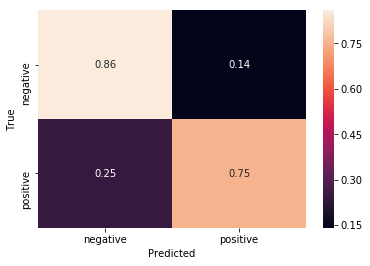

In [9]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_df["polarity"], 
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

# Saving model

In [60]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    sentence = tf.placeholder(dtype=tf.string, shape=[1, ], name='sentence')
    receiver_tensors = {'sentence': sentence}
    return tf.estimator.export.ServingInputReceiver(receiver_tensors, receiver_tensors)

estimator.export_saved_model('saved_model', serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.


I0408 22:25:53.493636 140296980215616 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 22:25:53.508442 140296980215616 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 22:25:53.536428 140296980215616 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0408 22:25:53.623291 140296980215616 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']


I0408 22:25:53.624383 140296980215616 export.py:587] Signatures INCLUDED in export for Classify: ['serving_default', 'classification']


INFO:tensorflow:Signatures INCLUDED in export for Regress: ['regression']


I0408 22:25:53.624945 140296980215616 export.py:587] Signatures INCLUDED in export for Regress: ['regression']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']


I0408 22:25:53.625443 140296980215616 export.py:587] Signatures INCLUDED in export for Predict: ['predict']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0408 22:25:53.626014 140296980215616 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0408 22:25:53.626620 140296980215616 export.py:587] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from /tmp/tmpmlu8d_w0/model.ckpt-3000


I0408 22:25:53.665685 140296980215616 saver.py:1270] Restoring parameters from /tmp/tmpmlu8d_w0/model.ckpt-3000


INFO:tensorflow:Assets added to graph.


I0408 22:25:53.883832 140296980215616 builder_impl.py:654] Assets added to graph.


INFO:tensorflow:Assets written to: saved_model/temp-b'1554733553'/assets


I0408 22:25:53.888701 140296980215616 builder_impl.py:763] Assets written to: saved_model/temp-b'1554733553'/assets


INFO:tensorflow:SavedModel written to: saved_model/temp-b'1554733553'/saved_model.pb


I0408 22:25:54.271098 140296980215616 builder_impl.py:414] SavedModel written to: saved_model/temp-b'1554733553'/saved_model.pb


b'saved_model/1554733553'

# Reload & predict

In [61]:
from pathlib import Path

In [62]:
export_dir = 'saved_model'
subdirs = [x for x in Path(export_dir).iterdir()
           if x.is_dir() and 'temp' not in str(x)]
latest = str(sorted(subdirs)[-1])

In [63]:
from tensorflow.contrib import predictor
predict_fn = predictor.from_saved_model(latest)

INFO:tensorflow:Restoring parameters from saved_model/1554733553/variables/variables


I0408 22:26:27.884939 140296980215616 saver.py:1270] Restoring parameters from saved_model/1554733553/variables/variables


In [64]:
test_df.iloc[0]['sentence']

"^^contains spoilers^^<br /><br />This movie is utter crap. Do not watch.<br /><br />There is no one in this movie to root for, or even like, except for the wife, and she wins by default. Everyone is selfish, and many things happen that make no sense.<br /><br />The acting is mediocre at best and everyone breathes too heavily about everything. No one can even cry believably.<br /><br />If you leave the room for even a second, then something totally out of left field will happen, and it will make NO SENSE WHATSOEVER.<br /><br />For example, I left the room for a second, while Jennie Garth's character was sleeping with her manager. I come back, seriously about 4 minutes later, (also I'm pretty sure there was a commercial somewhere in there) and she's sleeping with that Berko guy. <br /><br />I gave up on this movie around the time that Berko was being an ass to his fiancé in the car, because she didn't want to call off the wedding.<br /><br />I wasted 2 hours of my life. You shouldn't."

In [65]:
predict_fn({'inputs': [test_df.iloc[0]['sentence']]})

{'scores': array([[0.96812797, 0.03187205]], dtype=float32),
 'classes': array([[b'0', b'1']], dtype=object)}

# Other advanced modules

In [10]:
def train_and_evaluate_with_module(hub_module, train_module=False):
  embedded_text_feature_column = hub.text_embedding_column(
      key="sentence", module_spec=hub_module, trainable=train_module)

  estimator = tf.estimator.DNNClassifier(
      hidden_units=[500, 100],
      feature_columns=[embedded_text_feature_column],
      n_classes=2,
      optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

  estimator.train(input_fn=train_input_fn, steps=1000)

  train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
  test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

  training_set_accuracy = train_eval_result["accuracy"]
  test_set_accuracy = test_eval_result["accuracy"]

  return {
      "Training accuracy": training_set_accuracy,
      "Test accuracy": test_set_accuracy
  }


results = {}
results["nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1")
results["nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1", True)
results["random-nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1")
results["random-nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1", True)

INFO:tensorflow:Using default config.


I0404 01:19:03.538120 139753248302912 tf_logging.py:115] Using default config.


W0404 01:19:03.540275 139753248302912 tf_logging.py:125] Using temporary folder as model directory: /tmp/tmpy7phw131


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpy7phw131', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1a315e0048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0404 01:19:03.541198 139753248302912 tf_logging.py:115] Using config: {'_model_dir': '/tmp/tmpy7phw131', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1a315e0048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0404 01:19:03.560117 139753248302912 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:03.572340 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:03.596519 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0404 01:19:03.775445 139753248302912 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0404 01:19:03.776313 139753248302912 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0404 01:19:03.911953 139753248302912 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0404 01:19:04.148364 139753248302912 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0404 01:19:04.605593 139753248302912 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpy7phw131/model.ckpt.


I0404 01:19:04.787912 139753248302912 tf_logging.py:115] Saving checkpoints for 0 into /tmp/tmpy7phw131/model.ckpt.


INFO:tensorflow:loss = 88.16831, step = 0


I0404 01:19:05.182225 139753248302912 tf_logging.py:115] loss = 88.16831, step = 0


INFO:tensorflow:global_step/sec: 100.695


I0404 01:19:06.174901 139753248302912 tf_logging.py:115] global_step/sec: 100.695


INFO:tensorflow:loss = 56.007793, step = 100 (0.994 sec)


I0404 01:19:06.176506 139753248302912 tf_logging.py:115] loss = 56.007793, step = 100 (0.994 sec)


INFO:tensorflow:global_step/sec: 104.69


I0404 01:19:07.130109 139753248302912 tf_logging.py:115] global_step/sec: 104.69


INFO:tensorflow:loss = 61.94128, step = 200 (0.955 sec)


I0404 01:19:07.131610 139753248302912 tf_logging.py:115] loss = 61.94128, step = 200 (0.955 sec)


INFO:tensorflow:global_step/sec: 100.115


I0404 01:19:08.128985 139753248302912 tf_logging.py:115] global_step/sec: 100.115


INFO:tensorflow:loss = 55.863052, step = 300 (1.000 sec)


I0404 01:19:08.131258 139753248302912 tf_logging.py:115] loss = 55.863052, step = 300 (1.000 sec)


INFO:tensorflow:global_step/sec: 94.756


I0404 01:19:09.184314 139753248302912 tf_logging.py:115] global_step/sec: 94.756


INFO:tensorflow:loss = 58.24936, step = 400 (1.055 sec)


I0404 01:19:09.186291 139753248302912 tf_logging.py:115] loss = 58.24936, step = 400 (1.055 sec)


INFO:tensorflow:global_step/sec: 100.323


I0404 01:19:10.181083 139753248302912 tf_logging.py:115] global_step/sec: 100.323


INFO:tensorflow:loss = 55.46328, step = 500 (0.996 sec)


I0404 01:19:10.182541 139753248302912 tf_logging.py:115] loss = 55.46328, step = 500 (0.996 sec)


INFO:tensorflow:global_step/sec: 106.092


I0404 01:19:11.123654 139753248302912 tf_logging.py:115] global_step/sec: 106.092


INFO:tensorflow:loss = 59.602257, step = 600 (0.943 sec)


I0404 01:19:11.125090 139753248302912 tf_logging.py:115] loss = 59.602257, step = 600 (0.943 sec)


INFO:tensorflow:global_step/sec: 101.258


I0404 01:19:12.111233 139753248302912 tf_logging.py:115] global_step/sec: 101.258


INFO:tensorflow:loss = 50.274067, step = 700 (0.988 sec)


I0404 01:19:12.112631 139753248302912 tf_logging.py:115] loss = 50.274067, step = 700 (0.988 sec)


INFO:tensorflow:global_step/sec: 104.231


I0404 01:19:13.070638 139753248302912 tf_logging.py:115] global_step/sec: 104.231


INFO:tensorflow:loss = 53.434036, step = 800 (0.959 sec)


I0404 01:19:13.072015 139753248302912 tf_logging.py:115] loss = 53.434036, step = 800 (0.959 sec)


INFO:tensorflow:global_step/sec: 106.159


I0404 01:19:14.012626 139753248302912 tf_logging.py:115] global_step/sec: 106.159


INFO:tensorflow:loss = 60.57379, step = 900 (0.942 sec)


I0404 01:19:14.014203 139753248302912 tf_logging.py:115] loss = 60.57379, step = 900 (0.942 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpy7phw131/model.ckpt.


I0404 01:19:14.979262 139753248302912 tf_logging.py:115] Saving checkpoints for 1000 into /tmp/tmpy7phw131/model.ckpt.


INFO:tensorflow:Loss for final step: 61.089905.


I0404 01:19:15.636276 139753248302912 tf_logging.py:115] Loss for final step: 61.089905.


INFO:tensorflow:Calling model_fn.


I0404 01:19:15.651006 139753248302912 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:15.723208 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:15.747542 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


W0404 01:19:16.215807 139753248302912 tf_logging.py:125] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


W0404 01:19:16.230775 139753248302912 tf_logging.py:125] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


INFO:tensorflow:Done calling model_fn.


I0404 01:19:16.245766 139753248302912 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-04-03-17:19:16


I0404 01:19:16.261006 139753248302912 tf_logging.py:115] Starting evaluation at 2019-04-03-17:19:16


INFO:tensorflow:Graph was finalized.


I0404 01:19:16.411529 139753248302912 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpy7phw131/model.ckpt-1000


I0404 01:19:16.414360 139753248302912 tf_logging.py:115] Restoring parameters from /tmp/tmpy7phw131/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


I0404 01:19:16.638973 139753248302912 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0404 01:19:17.145847 139753248302912 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-04-03-17:19:19


I0404 01:19:19.362454 139753248302912 tf_logging.py:115] Finished evaluation at 2019-04-03-17:19:19


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.80236, accuracy_baseline = 0.5, auc = 0.8838542, auc_precision_recall = 0.883793, average_loss = 0.4295102, global_step = 1000, label/mean = 0.5, loss = 54.784462, precision = 0.81140316, prediction/mean = 0.48994055, recall = 0.78784


I0404 01:19:19.363297 139753248302912 tf_logging.py:115] Saving dict for global step 1000: accuracy = 0.80236, accuracy_baseline = 0.5, auc = 0.8838542, auc_precision_recall = 0.883793, average_loss = 0.4295102, global_step = 1000, label/mean = 0.5, loss = 54.784462, precision = 0.81140316, prediction/mean = 0.48994055, recall = 0.78784


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpy7phw131/model.ckpt-1000


I0404 01:19:19.468405 139753248302912 tf_logging.py:115] Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpy7phw131/model.ckpt-1000


INFO:tensorflow:Calling model_fn.


I0404 01:19:19.482131 139753248302912 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:19.494660 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:19.518737 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


W0404 01:19:20.052383 139753248302912 tf_logging.py:125] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


W0404 01:19:20.067623 139753248302912 tf_logging.py:125] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


INFO:tensorflow:Done calling model_fn.


I0404 01:19:20.083884 139753248302912 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-04-03-17:19:20


I0404 01:19:20.099979 139753248302912 tf_logging.py:115] Starting evaluation at 2019-04-03-17:19:20


INFO:tensorflow:Graph was finalized.


I0404 01:19:20.186082 139753248302912 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpy7phw131/model.ckpt-1000


I0404 01:19:20.187823 139753248302912 tf_logging.py:115] Restoring parameters from /tmp/tmpy7phw131/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


I0404 01:19:20.420415 139753248302912 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0404 01:19:20.904785 139753248302912 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-04-03-17:19:23


I0404 01:19:23.079009 139753248302912 tf_logging.py:115] Finished evaluation at 2019-04-03-17:19:23


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.7936, accuracy_baseline = 0.5, auc = 0.8769026, auc_precision_recall = 0.87859726, average_loss = 0.4402976, global_step = 1000, label/mean = 0.5, loss = 56.16041, precision = 0.8056805, prediction/mean = 0.48717466, recall = 0.77384


I0404 01:19:23.080085 139753248302912 tf_logging.py:115] Saving dict for global step 1000: accuracy = 0.7936, accuracy_baseline = 0.5, auc = 0.8769026, auc_precision_recall = 0.87859726, average_loss = 0.4402976, global_step = 1000, label/mean = 0.5, loss = 56.16041, precision = 0.8056805, prediction/mean = 0.48717466, recall = 0.77384


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpy7phw131/model.ckpt-1000


I0404 01:19:23.083057 139753248302912 tf_logging.py:115] Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpy7phw131/model.ckpt-1000


INFO:tensorflow:Using default config.


I0404 01:19:23.085654 139753248302912 tf_logging.py:115] Using default config.


W0404 01:19:23.086505 139753248302912 tf_logging.py:125] Using temporary folder as model directory: /tmp/tmpq19488mh


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpq19488mh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1a21d0def0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0404 01:19:23.087357 139753248302912 tf_logging.py:115] Using config: {'_model_dir': '/tmp/tmpq19488mh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1a21d0def0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0404 01:19:23.106207 139753248302912 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:23.119314 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:23.143133 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0404 01:19:23.334473 139753248302912 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0404 01:19:23.335588 139753248302912 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0404 01:19:23.478267 139753248302912 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0404 01:19:24.769747 139753248302912 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0404 01:19:25.233334 139753248302912 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpq19488mh/model.ckpt.


I0404 01:19:25.423772 139753248302912 tf_logging.py:115] Saving checkpoints for 0 into /tmp/tmpq19488mh/model.ckpt.


INFO:tensorflow:loss = 88.12094, step = 0


I0404 01:19:26.262056 139753248302912 tf_logging.py:115] loss = 88.12094, step = 0


INFO:tensorflow:global_step/sec: 42.7077


I0404 01:19:28.603159 139753248302912 tf_logging.py:115] global_step/sec: 42.7077


INFO:tensorflow:loss = 56.52323, step = 100 (2.345 sec)


I0404 01:19:28.607293 139753248302912 tf_logging.py:115] loss = 56.52323, step = 100 (2.345 sec)


INFO:tensorflow:global_step/sec: 43.08


I0404 01:19:30.924428 139753248302912 tf_logging.py:115] global_step/sec: 43.08


INFO:tensorflow:loss = 52.99573, step = 200 (2.320 sec)


I0404 01:19:30.926934 139753248302912 tf_logging.py:115] loss = 52.99573, step = 200 (2.320 sec)


INFO:tensorflow:global_step/sec: 43.7195


I0404 01:19:33.211694 139753248302912 tf_logging.py:115] global_step/sec: 43.7195


INFO:tensorflow:loss = 33.205036, step = 300 (2.286 sec)


I0404 01:19:33.213243 139753248302912 tf_logging.py:115] loss = 33.205036, step = 300 (2.286 sec)


INFO:tensorflow:global_step/sec: 54.321


I0404 01:19:35.052607 139753248302912 tf_logging.py:115] global_step/sec: 54.321


INFO:tensorflow:loss = 37.701347, step = 400 (1.841 sec)


I0404 01:19:35.054072 139753248302912 tf_logging.py:115] loss = 37.701347, step = 400 (1.841 sec)


INFO:tensorflow:global_step/sec: 63.584


I0404 01:19:36.625321 139753248302912 tf_logging.py:115] global_step/sec: 63.584


INFO:tensorflow:loss = 31.03404, step = 500 (1.573 sec)


I0404 01:19:36.626818 139753248302912 tf_logging.py:115] loss = 31.03404, step = 500 (1.573 sec)


INFO:tensorflow:global_step/sec: 65.2205


I0404 01:19:38.158583 139753248302912 tf_logging.py:115] global_step/sec: 65.2205


INFO:tensorflow:loss = 47.464478, step = 600 (1.534 sec)


I0404 01:19:38.161120 139753248302912 tf_logging.py:115] loss = 47.464478, step = 600 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.492


I0404 01:19:39.685491 139753248302912 tf_logging.py:115] global_step/sec: 65.492


INFO:tensorflow:loss = 28.544142, step = 700 (1.526 sec)


I0404 01:19:39.686952 139753248302912 tf_logging.py:115] loss = 28.544142, step = 700 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.4762


I0404 01:19:41.212758 139753248302912 tf_logging.py:115] global_step/sec: 65.4762


INFO:tensorflow:loss = 23.998728, step = 800 (1.528 sec)


I0404 01:19:41.214705 139753248302912 tf_logging.py:115] loss = 23.998728, step = 800 (1.528 sec)


INFO:tensorflow:global_step/sec: 53.2161


I0404 01:19:43.091892 139753248302912 tf_logging.py:115] global_step/sec: 53.2161


INFO:tensorflow:loss = 26.54721, step = 900 (1.879 sec)


I0404 01:19:43.093240 139753248302912 tf_logging.py:115] loss = 26.54721, step = 900 (1.879 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpq19488mh/model.ckpt.


I0404 01:19:44.694550 139753248302912 tf_logging.py:115] Saving checkpoints for 1000 into /tmp/tmpq19488mh/model.ckpt.


INFO:tensorflow:Loss for final step: 20.694061.


I0404 01:19:48.618357 139753248302912 tf_logging.py:115] Loss for final step: 20.694061.


INFO:tensorflow:Calling model_fn.


I0404 01:19:48.635723 139753248302912 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:48.649705 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:48.771280 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


W0404 01:19:49.256765 139753248302912 tf_logging.py:125] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


W0404 01:19:49.273875 139753248302912 tf_logging.py:125] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


INFO:tensorflow:Done calling model_fn.


I0404 01:19:49.291140 139753248302912 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-04-03-17:19:49


I0404 01:19:49.308385 139753248302912 tf_logging.py:115] Starting evaluation at 2019-04-03-17:19:49


INFO:tensorflow:Graph was finalized.


I0404 01:19:49.468405 139753248302912 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpq19488mh/model.ckpt-1000


I0404 01:19:49.471492 139753248302912 tf_logging.py:115] Restoring parameters from /tmp/tmpq19488mh/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


I0404 01:19:49.720099 139753248302912 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0404 01:19:50.258881 139753248302912 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-04-03-17:19:52


I0404 01:19:52.588042 139753248302912 tf_logging.py:115] Finished evaluation at 2019-04-03-17:19:52


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.94612, accuracy_baseline = 0.5, auc = 0.985744, auc_precision_recall = 0.98617625, average_loss = 0.15866989, global_step = 1000, label/mean = 0.5, loss = 20.238506, precision = 0.9374755, prediction/mean = 0.5129272, recall = 0.956


I0404 01:19:52.588983 139753248302912 tf_logging.py:115] Saving dict for global step 1000: accuracy = 0.94612, accuracy_baseline = 0.5, auc = 0.985744, auc_precision_recall = 0.98617625, average_loss = 0.15866989, global_step = 1000, label/mean = 0.5, loss = 20.238506, precision = 0.9374755, prediction/mean = 0.5129272, recall = 0.956


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpq19488mh/model.ckpt-1000


I0404 01:19:52.755853 139753248302912 tf_logging.py:115] Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpq19488mh/model.ckpt-1000


INFO:tensorflow:Calling model_fn.


I0404 01:19:52.771687 139753248302912 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:52.785134 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0404 01:19:52.814054 139753248302912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


W0404 01:19:53.403534 139753248302912 tf_logging.py:125] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


W0404 01:19:53.420145 139753248302912 tf_logging.py:125] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


INFO:tensorflow:Done calling model_fn.


I0404 01:19:53.438029 139753248302912 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-04-03-17:19:53


I0404 01:19:53.455136 139753248302912 tf_logging.py:115] Starting evaluation at 2019-04-03-17:19:53


INFO:tensorflow:Graph was finalized.


I0404 01:19:53.548064 139753248302912 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpq19488mh/model.ckpt-1000


I0404 01:19:53.551990 139753248302912 tf_logging.py:115] Restoring parameters from /tmp/tmpq19488mh/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


I0404 01:19:53.803518 139753248302912 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0404 01:19:54.294097 139753248302912 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-04-03-17:19:56


I0404 01:19:56.486992 139753248302912 tf_logging.py:115] Finished evaluation at 2019-04-03-17:19:56


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.87276, accuracy_baseline = 0.5, auc = 0.9443029, auc_precision_recall = 0.94339085, average_loss = 0.31220004, global_step = 1000, label/mean = 0.5, loss = 39.821434, precision = 0.8640519, prediction/mean = 0.5116947, recall = 0.88472


I0404 01:19:56.487890 139753248302912 tf_logging.py:115] Saving dict for global step 1000: accuracy = 0.87276, accuracy_baseline = 0.5, auc = 0.9443029, auc_precision_recall = 0.94339085, average_loss = 0.31220004, global_step = 1000, label/mean = 0.5, loss = 39.821434, precision = 0.8640519, prediction/mean = 0.5116947, recall = 0.88472


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpq19488mh/model.ckpt-1000


I0404 01:19:56.489483 139753248302912 tf_logging.py:115] Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpq19488mh/model.ckpt-1000


KeyboardInterrupt: 

In [ ]:
pd.DataFrame.from_dict(results, orient="index")

In [ ]:
estimator.evaluate(input_fn=predict_test_input_fn)["accuracy_baseline"]

In [ ]:
test_df['sentence'][0]